In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from astropy.modeling.models import BlackBody
from astropy.modeling.blackbody import blackbody_lambda

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)

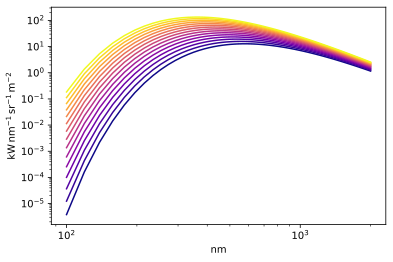

In [9]:
from cycler import cycler
from matplotlib import cm #colormap

i_units = "kW m-2 sr-1 nm-1" #more practical SI units

wave = np.linspace(100,2000,100) * units.nm
temp = np.linspace(5000,8000,15) * units.K
radiation = BlackBody(temp, scale=1.*units.Unit(i_units))(wave[:,np.newaxis])
fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0,1,len(temp)))) #going to go through the whole cm
ax.set_prop_cycle(custom_cycler) #change default colours of plots
ax.loglog(wave, radiation.to('kW m-2 nm-1 sr-1'));

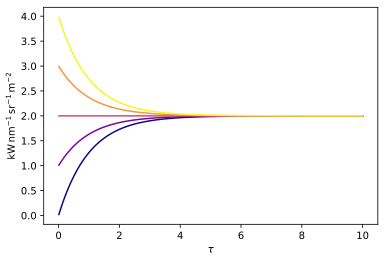

In [26]:
def isothermal_intensity(I0, tau):
    return I0*np.exp(-tau) + 2*(1 - np.exp(-tau))

tau = np.logspace(-2, 1, 100)
i0 = np.arange(5)

I_slab = isothermal_intensity(i0, tau[:,np.newaxis])*units.Unit(i_units)
    
fig, ax = plt.subplots()
custom_cycler = cycler('color', cm.plasma(np.linspace(0,1,len(i0)))) #going to go through the whole cm
ax.set_prop_cycle(custom_cycler) #change default colours of plots
ax.set_xlabel(r'$\tau$')
ax.plot(tau, I_slab);